In [1]:
import glob
import random

import numpy as np

from keyrover.datasets.multiclass_dataset import *
from keyrover.vision import *
from keyrover import *

datasets/raw/masks/keyboard_2860_2.png


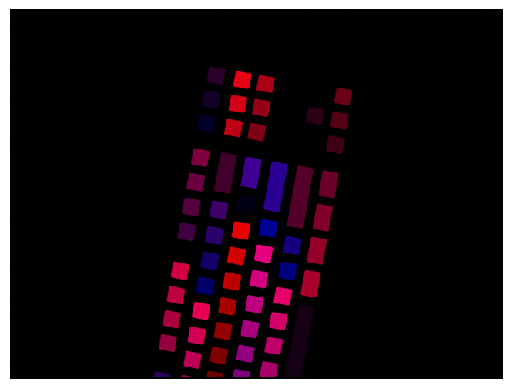

In [10]:
paths = glob.glob(f"{RAW_MASKS}/*.png")
mask_path = random.choice(paths)
print(mask_path)

image_path = f"{SEGMENTATION_DATASET}/{os.path.basename(mask_path).removesuffix('.png')}.jpg"

image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("RGB")
classes = np.array(mask)

imshow(classes)

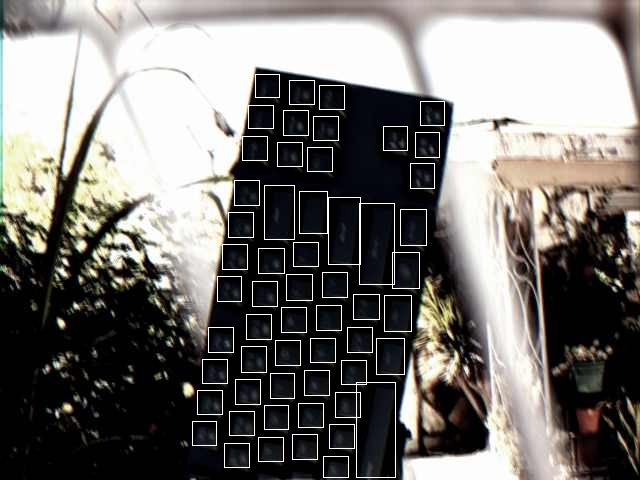

In [11]:
newimg = np.array(image)

OUTLIER_THRESHOLD = -0.5

rects = extract_rects(classes.mean(axis=-1) > 1)
areas = np.array(list(map(lambda rect: rect[-1] * rect[-2], rects)))

d = areas - np.median(areas)
mdev = np.median(areas)
s = d / mdev if mdev else np.zeros(len(d))

rects = zip(s, rects)
rects = list(filter(lambda rect: rect[0] > OUTLIER_THRESHOLD, rects))

_, rects = zip(*rects)

for rect in rects:
    cv2.rectangle(newimg, rect, (255, 255, 255), 1)

Image.fromarray(newimg)

In [12]:
palette = np.array([key_to_color(i) for i in range(118)])
palette[0], palette[-1]

(array([0, 0, 0]), array([189,   0, 189]))

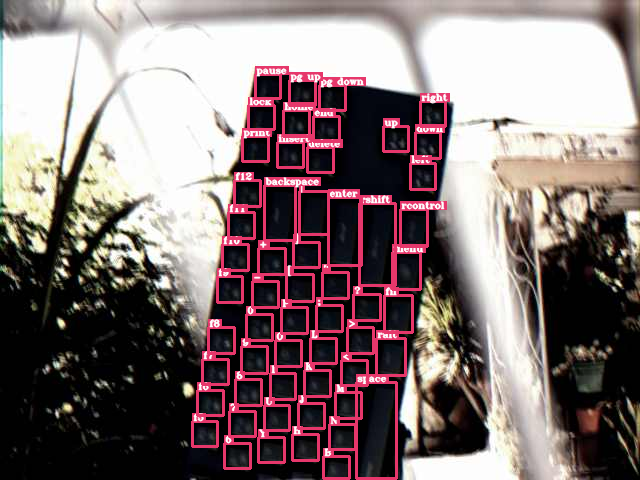

In [13]:
from scipy.spatial import cKDTree

crops = []

newimg = np.array(image)

for x, y, w, h in rects:
    crop = classes[y:y + h, x:x + w]
    crop = palette[cKDTree(palette).query(crop, k=1)[1]]
    crops.append(crop)
    
    crop = np.vstack(crop)
    crop = crop[(crop != 0).any(axis=-1)]
    color = np.median(crop, axis=0)
    
    i = color_to_key(color)
    draw_textbox(newimg, (x, y), (x + w, y + h), text=id_to_key.get(i, str(i)), scale=1, size=0.3)


Image.fromarray(newimg)